In [ ]:
!pip install monai
!pip install nibabel
#нужна именно эта версия, чтобы работали сети трансформеры из monai
!pip install einops==0.5.0
!pip install matplotlib
!pip install opencv-python

In [21]:
!pip install tqdm


Defaulting to user installation because normal site-packages is not writeable
  Using cached tqdm-4.66.1-py3-none-any.whl (78 kB)


Сделано на основе:
https://github.com/Project-MONAI/tutorials/blob/main/3d_segmentation/spleen_segmentation_3d.ipynb

In [1]:
from IPython.display import clear_output
import einops
clear_output()
from monai.utils import first, set_determinism
from monai.transforms import (
    AsDiscrete,
    AsDiscreted,
    EnsureChannelFirstd,
    EnsureChannelFirst,
    Rotate90,
    Compose,
    CropForegroundd,
    LoadImaged,
    Orientationd,
    RandCropByPosNegLabeld,
    SaveImaged,
    ScaleIntensityRanged,
    LoadImage,
    DivisiblePadd,
    Spacingd,
    SqueezeDimd,
    Resized,
    Resize,
    NormalizeIntensityd,
    Rotate90d,
    Invertd,
    SqueezeDim,
    ConcatItemsd,
    ToTensord,
)
from torch.utils.data import DataLoader
from monai.networks.utils import one_hot
import monai
from monai.handlers.utils import from_engine
from monai.networks.nets import UNet, UNETR, SwinUNETR, EfficientNetBN
from monai.networks.layers import Norm
from monai.metrics import DiceMetric
from monai.losses import DiceLoss, DiceCELoss
from monai.inferers import sliding_window_inference
from monai.data import CacheDataset, DataLoader, Dataset, decollate_batch
from monai.config import print_config
from monai.apps import download_and_extract
import torch
import matplotlib.pyplot as plt
import tempfile
import shutil
import os
import glob
import json
from PIL import Image
import cv2
import nibabel as nib
import numpy as np
from scipy import ndimage
print_config()
import pickle
from monai.data import MetaTensor
#!pip install 'monai[einops]'


MONAI version: 1.3.0
Numpy version: 1.26.2
Pytorch version: 2.1.2+cu121
MONAI flags: HAS_EXT = False, USE_COMPILED = False, USE_META_DICT = False
MONAI rev id: 865972f7a791bf7b42efbcd87c8402bd865b329e
MONAI __file__: /home/<username>/.local/lib/python3.10/site-packages/monai/__init__.py

Optional dependencies:
Pytorch Ignite version: NOT INSTALLED or UNKNOWN VERSION.
ITK version: NOT INSTALLED or UNKNOWN VERSION.
Nibabel version: 5.2.0
scikit-image version: NOT INSTALLED or UNKNOWN VERSION.
scipy version: 1.11.4
Pillow version: 10.1.0
Tensorboard version: NOT INSTALLED or UNKNOWN VERSION.
gdown version: NOT INSTALLED or UNKNOWN VERSION.
TorchVision version: NOT INSTALLED or UNKNOWN VERSION.
tqdm version: 4.66.1
lmdb version: NOT INSTALLED or UNKNOWN VERSION.
psutil version: 5.9.7
pandas version: NOT INSTALLED or UNKNOWN VERSION.
einops version: 0.5.0
transformers version: NOT INSTALLED or UNKNOWN VERSION.
mlflow version: NOT INSTALLED or UNKNOWN VERSION.
pynrrd version: NOT INSTALLED o

In [2]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Wed Jan  3 14:09:32 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.129.03             Driver Version: 535.129.03   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA RTX A4000               Off | 0000E493:00:00.0 Off |                  Off |
| 30%   24C    P0              31W / 140W |      1MiB / 16376MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [3]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 24.6 gigabytes of available RAM

You are using a high-RAM runtime!


## Load dataset

In [4]:
train_images = sorted(glob.glob(os.path.join('/home/usr/kidney_stones/short_dataset/images', "*.nii.gz")))
train_labels = sorted(glob.glob(os.path.join('/home/usr/kidney_stones/short_dataset/labels', "*.nii.gz")))
data_dicts = [{"image": image_name, "label": label_name} for image_name, label_name in zip(train_images, train_labels)]

In [5]:
train_files, val_files = data_dicts[:8], data_dicts[8:10]
set_determinism(seed=0)

In [6]:
val_files

[{'image': '/home/usr/kidney_stones/short_dataset/images/patient_data9.nii.gz',
  'label': '/home/usr/kidney_stones/short_dataset/labels/patient_label_9.nii.gz'}]

In [7]:
train_files

[{'image': '/home/usr/kidney_stones/short_dataset/images/patient_data1.nii.gz',
  'label': '/home/usr/kidney_stones/short_dataset/labels/patient_label_1.nii.gz'},
 {'image': '/home/usr/kidney_stones/short_dataset/images/patient_data10.nii.gz',
  'label': '/home/usr/kidney_stones/short_dataset/labels/patient_label_10.nii.gz'},
 {'image': '/home/usr/kidney_stones/short_dataset/images/patient_data2.nii.gz',
  'label': '/home/usr/kidney_stones/short_dataset/labels/patient_label_2.nii.gz'},
 {'image': '/home/usr/kidney_stones/short_dataset/images/patient_data3.nii.gz',
  'label': '/home/usr/kidney_stones/short_dataset/labels/patient_label_3.nii.gz'},
 {'image': '/home/usr/kidney_stones/short_dataset/images/patient_data4.nii.gz',
  'label': '/home/usr/kidney_stones/short_dataset/labels/patient_label_4.nii.gz'},
 {'image': '/home/usr/kidney_stones/short_dataset/images/patient_data5.nii.gz',
  'label': '/home/usr/kidney_stones/short_dataset/labels/patient_label_5.nii.gz'},
 {'image': '/home/us

# Cheak trasform and dataloader

In [14]:
transforms = Compose([
    LoadImaged(keys=("image", 'label'),image_only=False, reader="NibabelReader"),
    EnsureChannelFirstd(keys=["image"], channel_dim="no_channel"),
    ScaleIntensityRanged(
            keys=["image"],
            a_min=-57,
            a_max=164,
            b_min=0.0,
            b_max=1.0,
            clip=True,
        ),
    NormalizeIntensityd(keys=['image']),
    #Resized(keys=['image','label'], spatial_size=[300, 300, 0]),
    # DivisiblePadd(["image", "label"], 16), #depth  need to be divisible by a factor of 2**4=16.
    Rotate90d(keys=["image"], k =3, spatial_axes=[1, 0]),
 ])



In [15]:
def inverse_order(image):
  image = np.array(image)
  part = (image[0,:,:,:])
  # Получаем обратный массив
  part = np.flip(part)
  image[0, :,:,: ] = part
  return image

{'image': '/home/usr/kidney_stones/short_dataset/images/patient_data4.nii.gz', 'label': '/home/usr/kidney_stones/short_dataset/labels/patient_label_4.nii.gz'}
(1, 512, 512, 128)
(512, 512, 128)


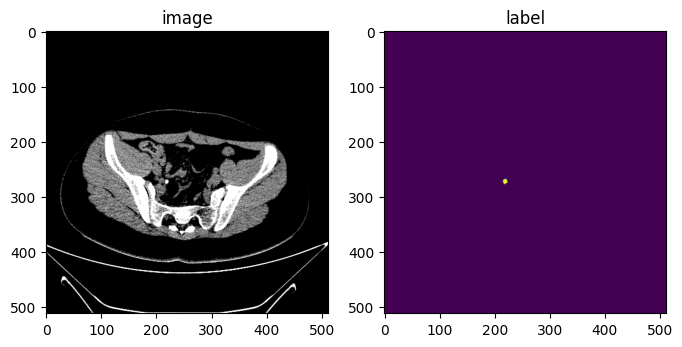

In [17]:
import numpy as np
i = 4
data_dict = transforms(train_files[i])
print(train_files[i])
print(np.shape(data_dict['image']))
print(np.shape(data_dict['label']))

image, label = data_dict["image"], data_dict["label"]

plt.figure("visualize", (8, 4))
plt.subplot(1, 2, 1)
plt.title("image")
k = 63
if i==3:
  image = inverse_order(image)
  image = np.rot90(image[0,:, :, k],2)
  mask = label[ :, :, k]
elif i==2:
  image = inverse_order(image)
  image = np.rot90(image[0,:, :, k],2)
  mask = label[ :, :, k]
elif i==1 or i==0 or i==5:
  image = image[0,:, :, k]
  mask = label[ :, :, k]
elif i==4:
  image = image[0,:, :, k]
  mask = np.rot90(label[ :, :, k],1)

plt.imshow(image, cmap="gray")
plt.subplot(1, 2, 2)
plt.title("label")
#иначе маска зеркально отображена
mask = label[ :, :, k]
mask = np.rot90(mask,4)
plt.imshow(mask)
plt.show()

# Define CacheDataset and DataLoader for training and validation

Here we use CacheDataset to accelerate training and validation process, it's 10x faster than the regular Dataset.
To achieve best performance, set cache_rate=1.0 to cache all the data, if memory is not enough, set lower value.
Users can also set cache_num instead of cache_rate, will use the minimum value of the 2 settings.
And set num_workers to enable multi-threads during caching.
If want to to try the regular Dataset, just change to use the commented code below.

Размер изображения 256х256 не умешается на GPU,  192x192 работает

In [8]:
train_transforms = Compose(
 [
 LoadImaged(keys=("image", 'label'), image_only=True, ensure_channel_first=True) ,
 ScaleIntensityRanged(
            keys=["image"],
            a_min=-57,
            a_max=164,
            b_min=0.0,
            b_max=1.0,
            clip=True,
        ),

 Rotate90d(keys=["image"], k =1, spatial_axes=[1, 0]),
 NormalizeIntensityd(keys=['image']),
 Resized(keys=["image", "label"], spatial_size=(192, 192, 0)), #width/height is a 64 step #192
 ])

val_transforms = Compose(
 [
 LoadImaged(keys=("image", 'label'), image_only=True, ensure_channel_first=True) ,
  ScaleIntensityRanged(
            keys=["image"],
            a_min=-57,
            a_max=164,
            b_min=0.0,
            b_max=1.0,
            clip=True,
        ),
 NormalizeIntensityd(keys=['image']),
 Rotate90d(keys=["image"], k =1, spatial_axes=[1, 0]),
 Resized(keys=["image", "label"], spatial_size=(192, 192, 0)),
 #DivisiblePadd(["image", "label"], 16),
 #ToTensord(keys=["inputs"]),
 ])

In [9]:
train_ds = CacheDataset(data=train_files, transform=train_transforms, cache_rate=0.2, num_workers=4)
#train_ds = Dataset(data=train_files, transform=train_transforms)

# use batch_size=2 to load images and use RandCropByPosNegLabeld
# to generate 2 x 4 images for network training
train_loader = DataLoader(train_ds, batch_size=1, shuffle=False, num_workers=0)
val_ds = CacheDataset(data=val_files, transform=val_transforms, cache_rate=0.2, num_workers=4)
#val_ds = Dataset(data=val_files, transform=val_transforms)
val_loader = DataLoader(val_ds, batch_size=1,shuffle=False, num_workers=0)


Loading dataset: 100%|██████████| 1/1 [00:03<00:00,  3.33s/it]


так как маски перевернуты, причину я не обнаружила, я сделала исключения, для определенных файлов

In [11]:
def find_length_seq(k, n):
  length= 0
  i=0
  while length < n:
    length = k*i
    i += 1
  return length - k

def prepare_one_batch(batch_data, i, train_files):
  image, label = np.array(batch_data["image"]), np.array(batch_data["label"])
  basename = os.path.basename(train_files[i]['image'])

  if basename=='patient_data2.nii.gz':
    part = (image[0,0,:,:,:])
    # Получаем обратный массив
    part = np.flip(part)
    image[0, 0, :,:,: ] = part
    rot_part = np.rot90(image[0,0,:, :, :],2)
    image = image

  else:

    part = (image[0,0,:,:,:])
    part = np.flip(part)
    image[0, 0, :,:,: ] = part

  return image, label

проверка того, что разметка камней корректна во всех файлах 

train

0
{'image': '/home/usr/kidney_stones/short_dataset/images/patient_data1.nii.gz', 'label': '/home/usr/kidney_stones/short_dataset/labels/patient_label_1.nii.gz'}


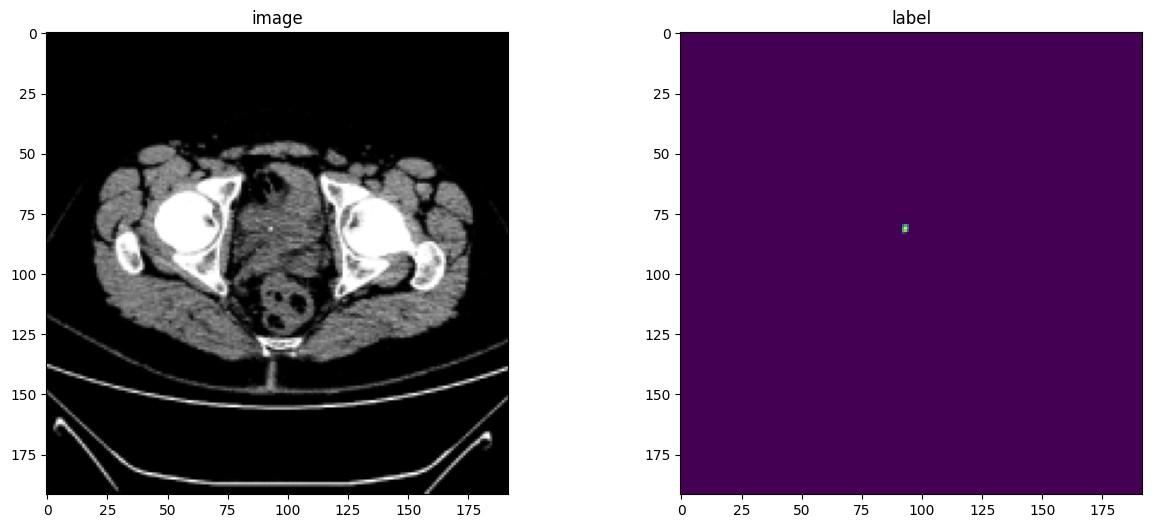

1
{'image': '/home/usr/kidney_stones/short_dataset/images/patient_data10.nii.gz', 'label': '/home/usr/kidney_stones/short_dataset/labels/patient_label_10.nii.gz'}


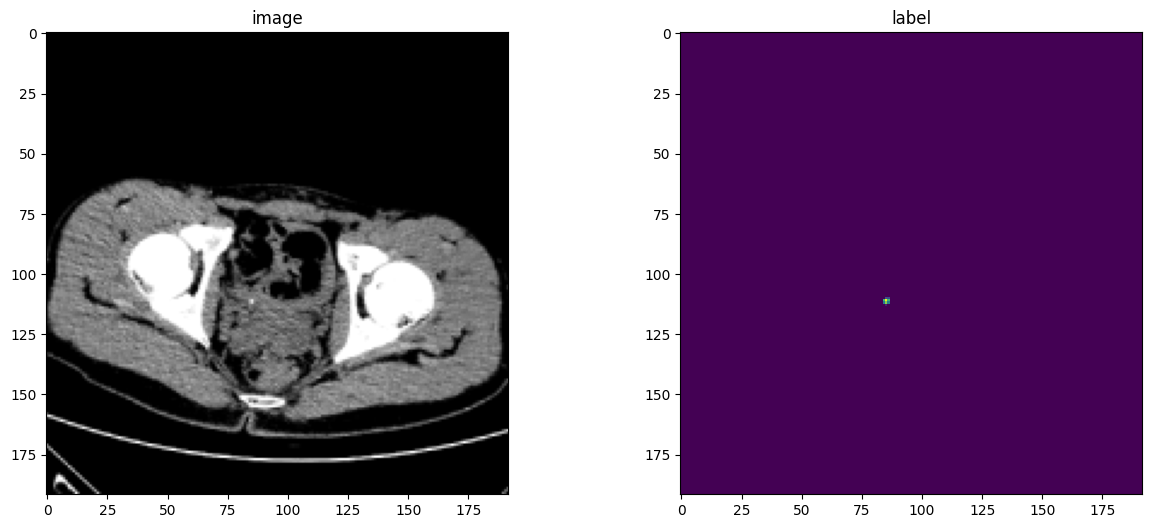

2
{'image': '/home/usr/kidney_stones/short_dataset/images/patient_data2.nii.gz', 'label': '/home/usr/kidney_stones/short_dataset/labels/patient_label_2.nii.gz'}


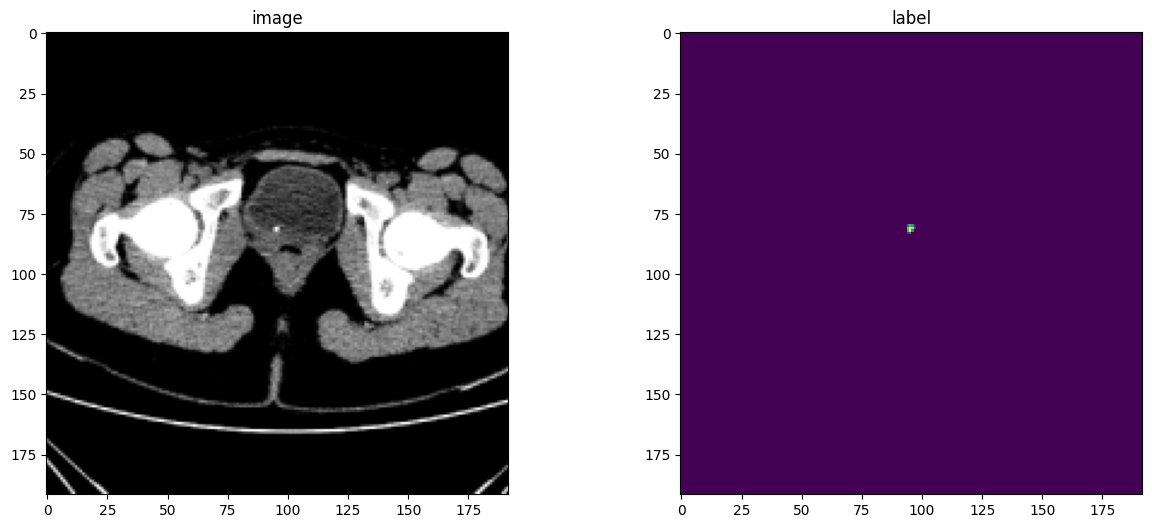

3
{'image': '/home/usr/kidney_stones/short_dataset/images/patient_data3.nii.gz', 'label': '/home/usr/kidney_stones/short_dataset/labels/patient_label_3.nii.gz'}


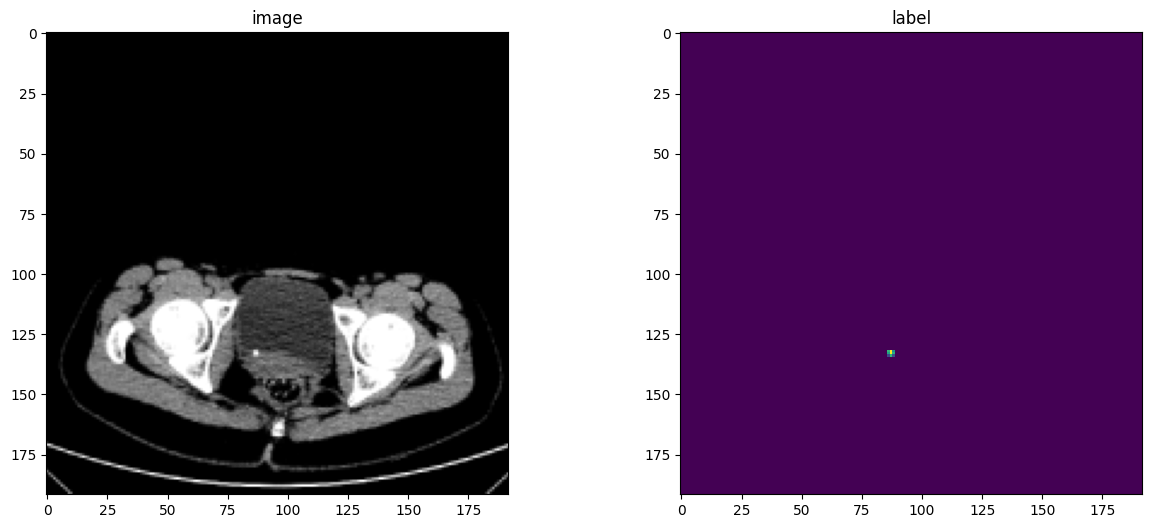

4
{'image': '/home/usr/kidney_stones/short_dataset/images/patient_data4.nii.gz', 'label': '/home/usr/kidney_stones/short_dataset/labels/patient_label_4.nii.gz'}


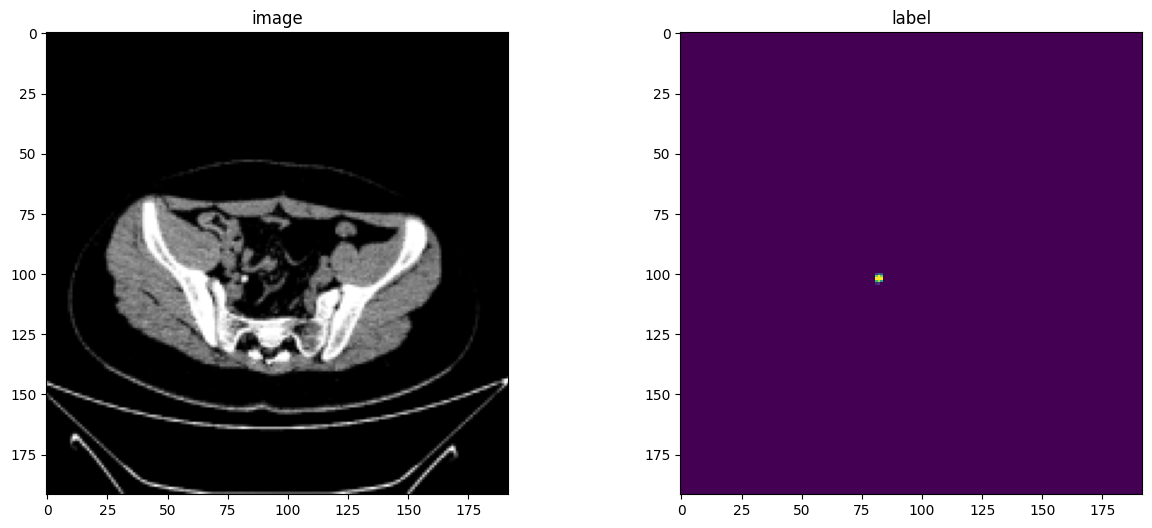

5
{'image': '/home/usr/kidney_stones/short_dataset/images/patient_data5.nii.gz', 'label': '/home/usr/kidney_stones/short_dataset/labels/patient_label_5.nii.gz'}


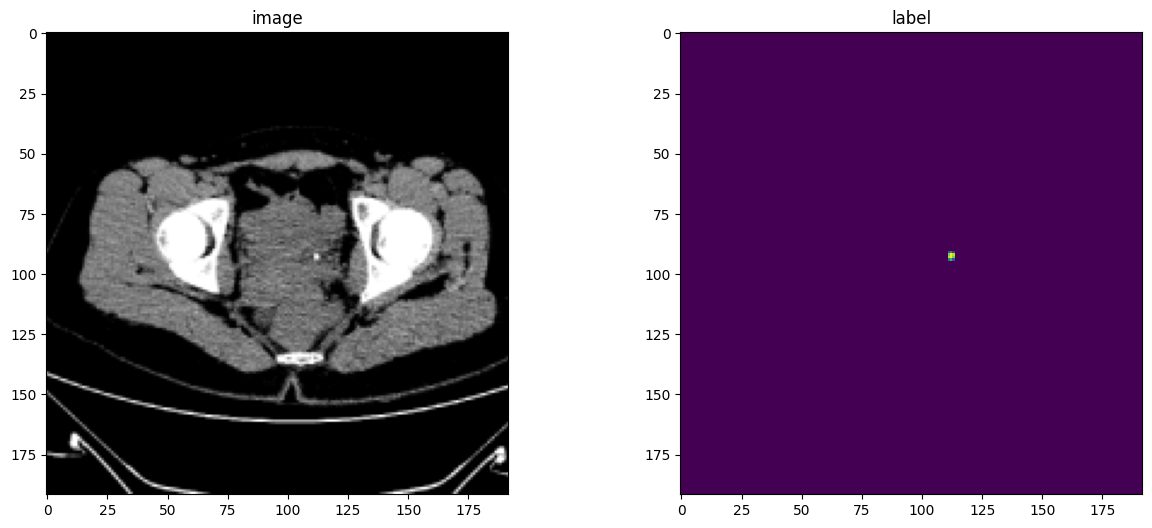

6
{'image': '/home/usr/kidney_stones/short_dataset/images/patient_data6.nii.gz', 'label': '/home/usr/kidney_stones/short_dataset/labels/patient_label_6.nii.gz'}


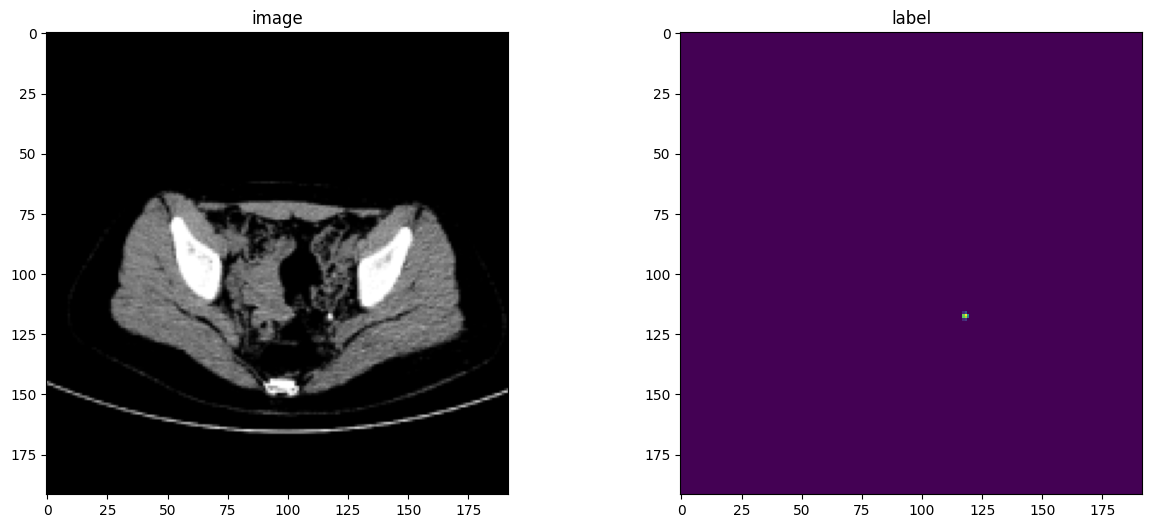

7
{'image': '/home/usr/kidney_stones/short_dataset/images/patient_data7.nii.gz', 'label': '/home/usr/kidney_stones/short_dataset/labels/patient_label_7.nii.gz'}


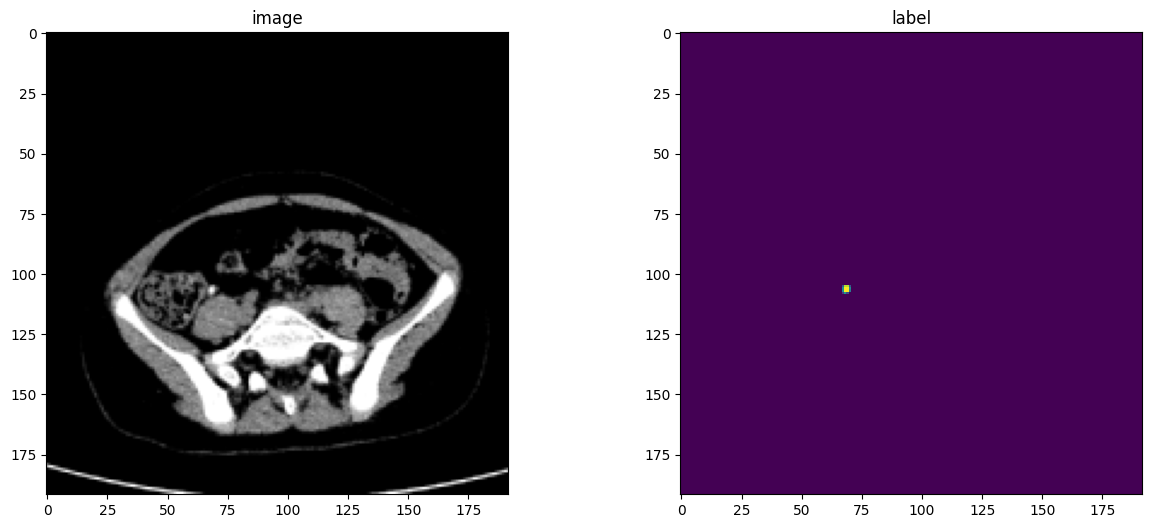

In [12]:
for i,batch_data in enumerate(train_loader):
  print(i)
  print(train_files[i])
  image, label = prepare_one_batch(batch_data, i, train_files)
  #image = MetaTensor(image)
  plt.figure("visualize", (15, 6))
  plt.subplot(1, 2, 1)
  plt.title("image")
  # plt.imshow(image, cmap="gray")
  if i==2:
    k=123
  elif i==3:
    k = 69
  else:
    k = 63
  plt.imshow(image[0,0,:, :, k], cmap="gray")
  plt.subplot(1, 2, 2)
  plt.title("label")
  # plt.imshow(label, interpolation ='nearest')
  plt.imshow(label[0,0, :, :, k], interpolation ='nearest')
  plt.show()



test

0
{'image': '/home/usr/kidney_stones/short_dataset/images/patient_data9.nii.gz', 'label': '/home/usr/kidney_stones/short_dataset/labels/patient_label_9.nii.gz'}


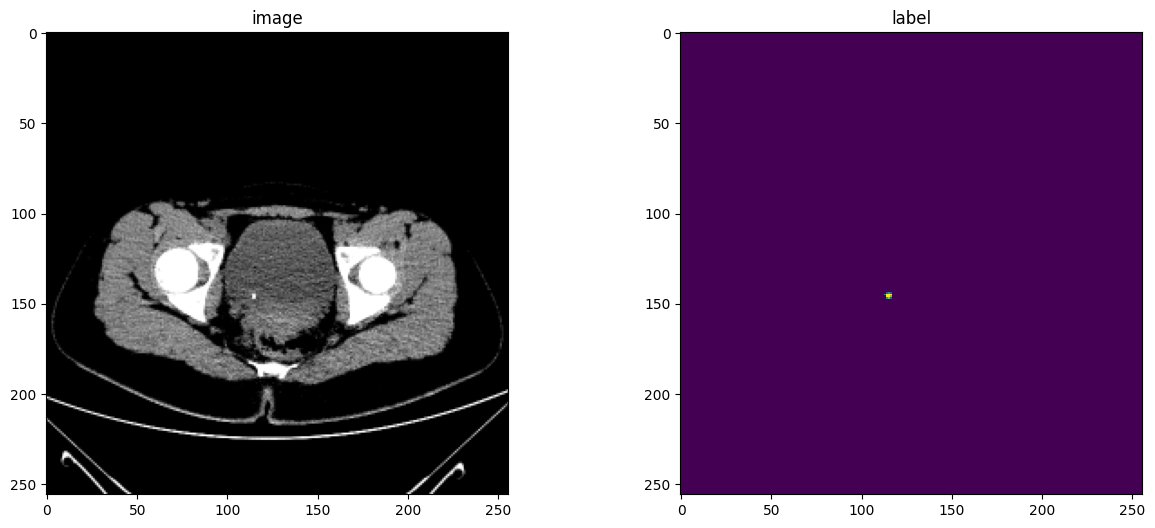

In [25]:
for i,batch_data in enumerate(val_loader):
  print(i)
  print(val_files[i])
  image, label = prepare_one_batch(batch_data, i,val_files)
  #image = MetaTensor(image)
  plt.figure("visualize", (15, 6))
  plt.subplot(1, 2, 1)
  plt.title("image")
  # plt.imshow(image, cmap="gray")
  if i==2:
    k=123
  elif i==3:
    k = 69
  else:
    k = 63
  plt.imshow(image[0,0,:, :, k], cmap="gray")
  plt.subplot(1, 2, 2)
  plt.title("label")
  # plt.imshow(label, interpolation ='nearest')
  plt.imshow(label[0,0, :, :, k], interpolation ='nearest')
  plt.show()


In [ ]:
check_data = monai.utils.misc.first(val_loader)
print(check_data["image"].shape, check_data["label"].shape)
print(check_data["label"])

torch.Size([1, 1, 192, 192, 128]) torch.Size([1, 1, 192, 192, 128])
metatensor([[[[[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           ...,
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.]],

          [[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           ...,
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.]],

          [[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           ...,
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.]],

          ...,

          [[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.]

# Create Model, Loss, Optimizer

В SwinUNETR умешается только если размер одного файла урезать с (192, 192, 128) до (192, 192, 64)

In [14]:
# standard PyTorch program style: create UNet, DiceLoss and Adam optimizer
import numpy as np
device = torch.device("cuda:0")

#### ВЫБОР МОДЕЛИ ####

# model = UNet(
#     spatial_dims=3, in_channels=1,
#     out_channels=2, channels=(16, 32, 64, 128, 256),
#     strides=(2, 2, 2, 2), num_res_units=2,
#     norm=Norm.BATCH, ).to(device)

model = UNETR(in_channels=1, out_channels=2, img_size=(192, 192, 128), feature_size=16, norm_name='instance').to(device)
#model = SwinUNETR(img_size=(192, 192, 64), in_channels=1, out_channels=2, depths=(2,4,2,2), feature_size=12).to(device) 
# model = EfficientNetBN("efficientnet-b0", pretrained=True, spatial_dims=3)

#### ВЫБОР loss_function ####
loss_function = DiceLoss(include_background =True, to_onehot_y=True, softmax=True) #If include_background is False then class 0 is discarded from the loss/score calculation.
# loss_function = DiceCELoss(include_background =True, to_onehot_y=True, softmax=True)
# loss_function = GeneralizedWassersteinDiceLoss(dist_matrix=dist_mat)

#### ВЫБОР optimizer ####
# optimizer = torch.optim.Adam(model.parameters(), 1e-4)
# optimizer = torch.optim.SGD(model.parameters(), lr=0.005, momentum=0.8)
optimizer = torch.optim.AdamW(model.parameters(), lr=0.001, weight_decay=0.01)

dice_metric_background = DiceMetric(include_background=True, reduction="mean")
dice_metric_obj = DiceMetric(include_background=False, reduction="mean")


In [16]:
max_epochs = 5
val_interval = 2
best_metric = -1
best_metric_epoch = -1
epoch_loss_values = []
metric_values = []
root_dir = '/home/usr/kidney_stones/weight'
post_pred = Compose([AsDiscrete(argmax=True, to_onehot=2)])
post_label = Compose([AsDiscrete(to_onehot=2)])

for epoch in range(max_epochs):
    print("-" * 10)
    print(f"epoch {epoch + 1}/{max_epochs}")
    model.train()
    epoch_loss = 0
    step = 0
    for i, batch_data in enumerate(train_loader):
        step += 1
        # inputs, labels = (
        #     batch_data["image"],
        #     batch_data["label"],
            # batch_data["image"].to(device),
            # batch_data["label"].to(device),
        #  )
        inputs, labels = prepare_one_batch(batch_data, i, train_files)

        # print(inputs)
        inputs, labels = MetaTensor(inputs).to(device), MetaTensor(labels).to(device)
        # print(np.shape(inputs))
        optimizer.zero_grad()
        outputs = model(inputs)
        # print('outputs', np.shape(outputs))
        #print('labels', np.shape(labels))
        #labels_encode = one_hot(labels[0], num_classes=2, dim=0)
        #target = one_hot(labels[:, None, ...], num_classes=2)
        #labels[0] = labels_encode
        #print('target', np.shape(target))

        loss = loss_function(outputs, labels) #outputs - BNH[WD].target - BNH[WD] or B1H[WD].

        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        print(f"{step}/{len(train_ds) // train_loader.batch_size}, " f"train_loss: {loss.item():.4f}")
    epoch_loss /= step
    epoch_loss_values.append(epoch_loss)
    a = {'loss': epoch_loss_values}
    #with open(os.path.join(root_dir, "Adam_UNETR_loss.pickle"), 'wb') as handle:
      #pickle.dump(a, handle, protocol=pickle.HIGHEST_PROTOCOL)
    print(f"epoch {epoch + 1} average loss: {epoch_loss:.4f}")

    model.eval()
    with torch.no_grad():
        for i, val_data in enumerate(val_loader):
            val_inputs, val_labels = prepare_one_batch(val_data, i, val_files)
            # print(np.shape(inputs))
            # print(inputs)
            val_inputs, val_labels = MetaTensor(val_inputs).to(device), MetaTensor(val_labels).to(device)
            roi_size = (192, 192, 128) #### не забывать менять при изменении размера батча
            sw_batch_size = 4
            val_outputs = sliding_window_inference(val_inputs, roi_size, sw_batch_size, model)
            val_outputs = [post_pred(i) for i in decollate_batch(val_outputs)]
            val_labels = [post_label(i) for i in decollate_batch(val_labels)]
            # compute metric for current iteration
            dice_metric_obj(y_pred=val_outputs, y=val_labels)
            dice_metric_background(y_pred=val_outputs, y=val_labels)

        # aggregate the final mean dice result
        metric_obj = dice_metric_obj.aggregate().item()
        metric = dice_metric_background.aggregate().item()
        # reset the status for next validation round
        dice_metric_obj.reset()
        dice_metric_background.reset()

        metric_values.append(metric)
        b = {'metric': metric}
        #with open(os.path.join(root_dir, "Adam_UNETR_metric.pickle"), 'wb') as handle:
        #  pickle.dump(b, handle, protocol=pickle.HIGHEST_PROTOCOL)

        torch.save(model.state_dict(), os.path.join(root_dir, "Adam_UNETR_metric_model_{}.pth".format(epoch+1)))
        if metric > best_metric:
            best_metric = metric
            best_metric_epoch = epoch + 1
            torch.save(model.state_dict(), os.path.join(root_dir, "best_metric_model_{}.pth".format(epoch+1)))
            print("saved new best metric model")
        print(
            f"current epoch: {epoch + 1} current mean dice (фон и obj): {metric:.4f}  current mean dice объекта {metric_obj:.4f}"
            f"\nbest mean dice: {best_metric:.4f} "
            f"at epoch: {best_metric_epoch}"
        )

----------
epoch 1/5
1/8, train_loss: 0.5488
2/8, train_loss: 0.5445
3/8, train_loss: 0.5430
4/8, train_loss: 0.5461
5/8, train_loss: 0.5463
6/8, train_loss: 0.5391
7/8, train_loss: 0.5440
8/8, train_loss: 0.5429
epoch 1 average loss: 0.5443
saved new best metric model
current epoch: 1 current mean dice (фон и obj): 0.5000  current mean dice объекта0.0000
best mean dice: 0.5000 at epoch: 1
----------
epoch 2/5
1/8, train_loss: 0.5374
2/8, train_loss: 0.5344
3/8, train_loss: 0.5337
4/8, train_loss: 0.5372
5/8, train_loss: 0.5375
6/8, train_loss: 0.5314
7/8, train_loss: 0.5362
8/8, train_loss: 0.5352
epoch 2 average loss: 0.5354
current epoch: 2 current mean dice (фон и obj): 0.5000  current mean dice объекта0.0000
best mean dice: 0.5000 at epoch: 1
----------
epoch 3/5
1/8, train_loss: 0.5302
2/8, train_loss: 0.5283
3/8, train_loss: 0.5277
4/8, train_loss: 0.5304
5/8, train_loss: 0.5310
6/8, train_loss: 0.5259
7/8, train_loss: 0.5301
8/8, train_loss: 0.5293
epoch 3 average loss: 0.5291


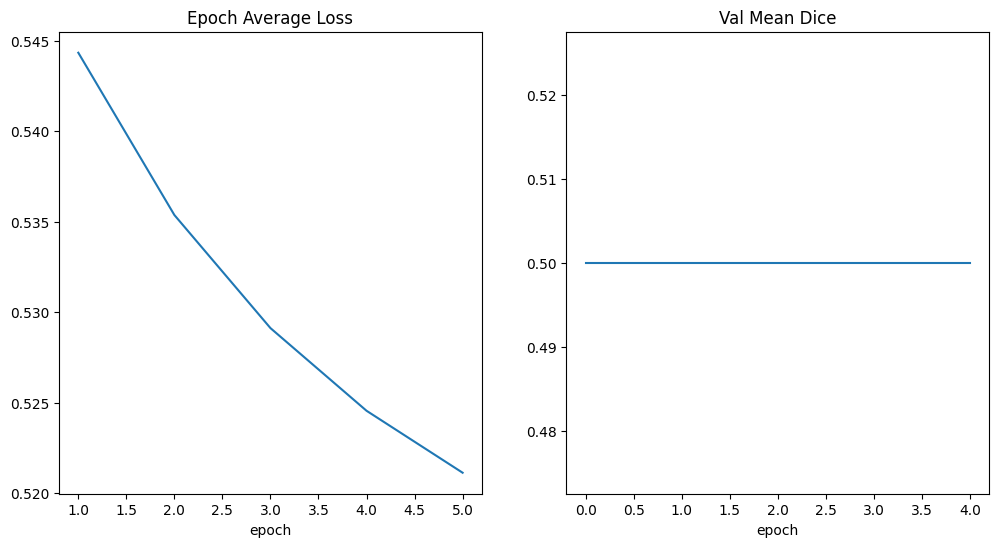

In [17]:
plt.figure("train", (12, 6))
plt.subplot(1, 2, 1)
plt.title("Epoch Average Loss")
x = [i + 1 for i in range(len(epoch_loss_values))]
y = epoch_loss_values
plt.xlabel("epoch")
plt.plot(x, y)
plt.subplot(1, 2, 2)
plt.title("Val Mean Dice")
y = metric_values
plt.xlabel("epoch")
plt.plot(metric_values)

#plt.savefig('/content/drive/MyDrive/Medtech_dataset/dataset/foo.png')
plt.show()

Check best model output with the input image and label

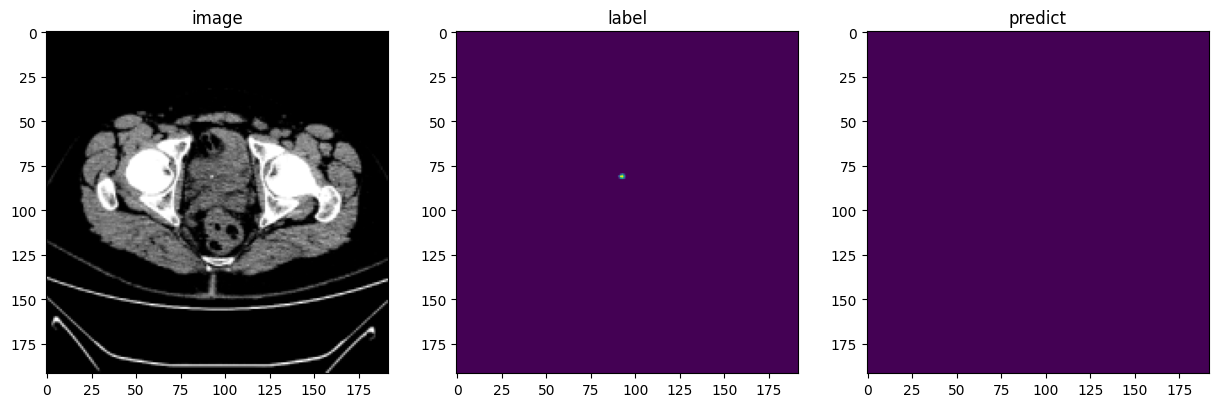

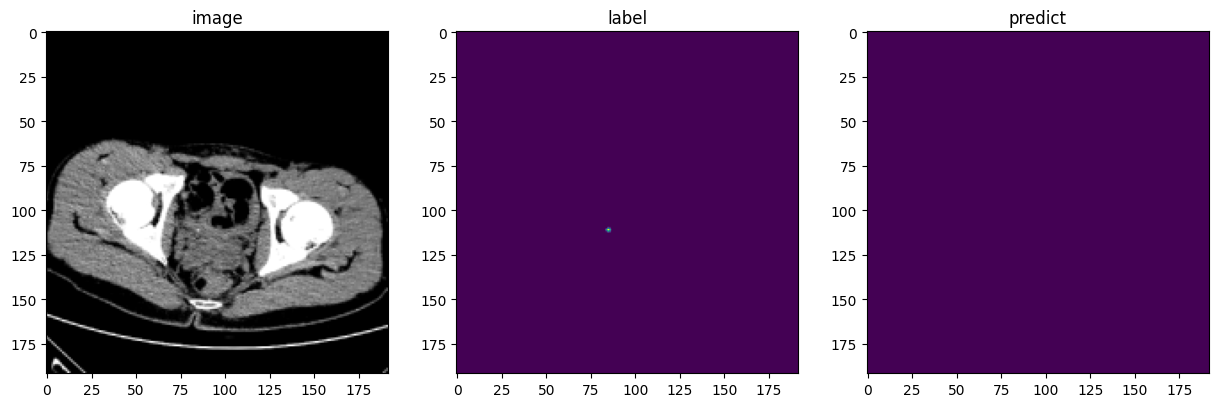

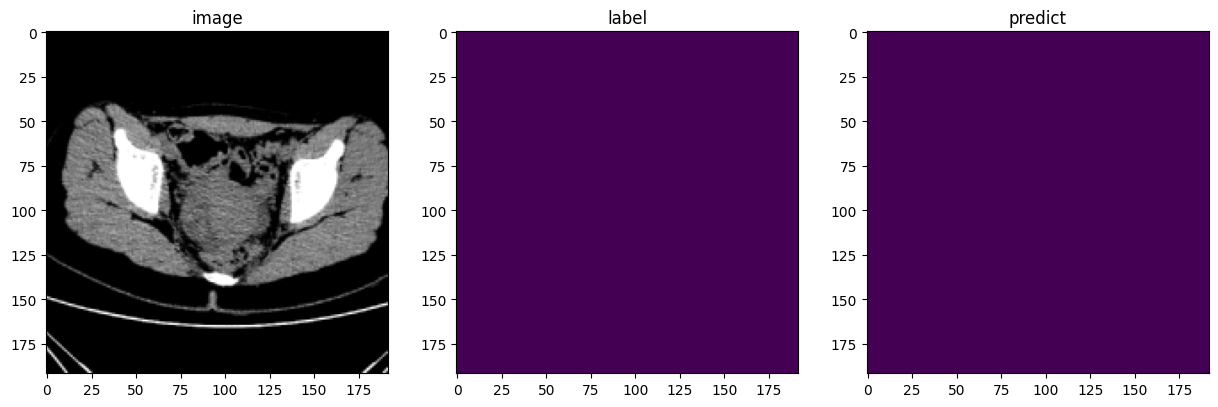

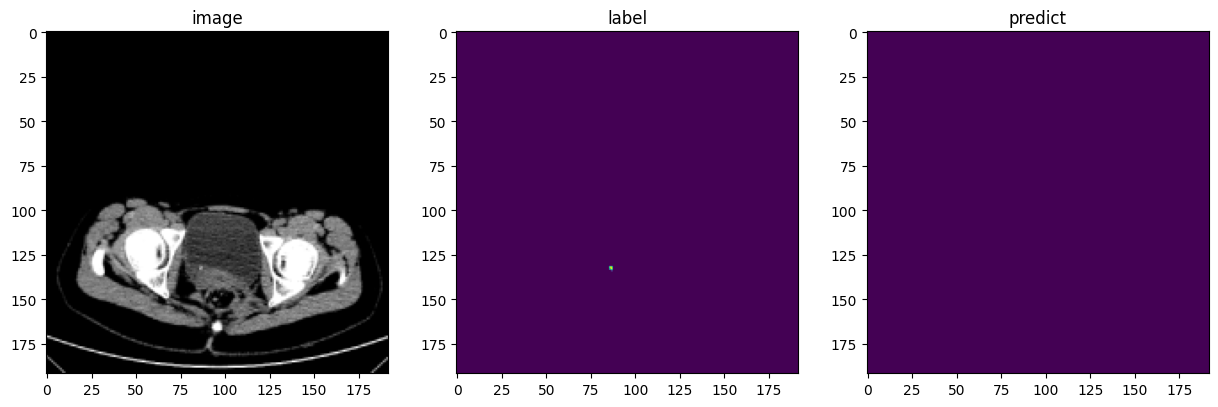

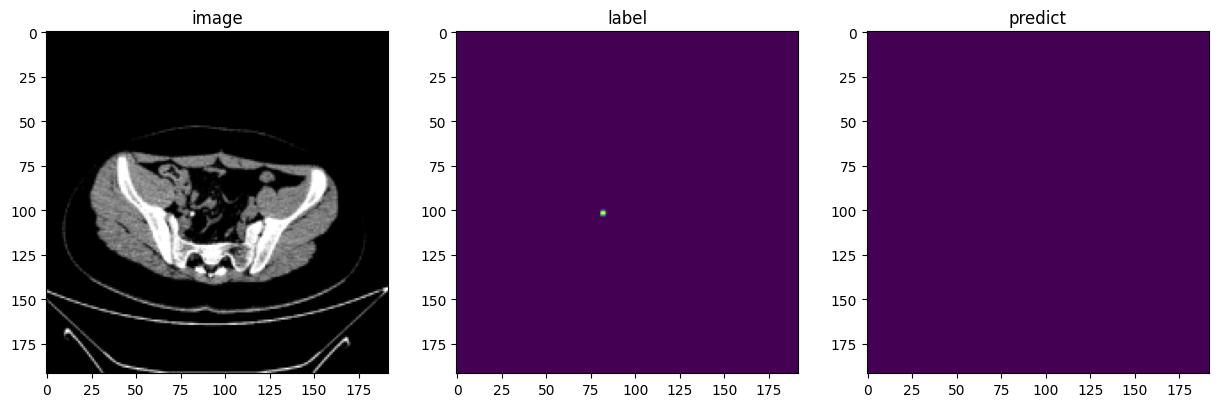

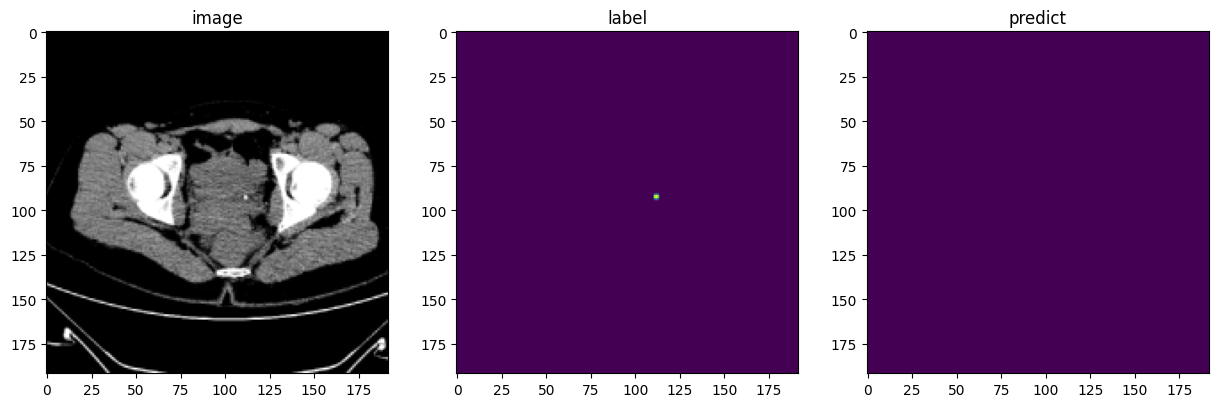

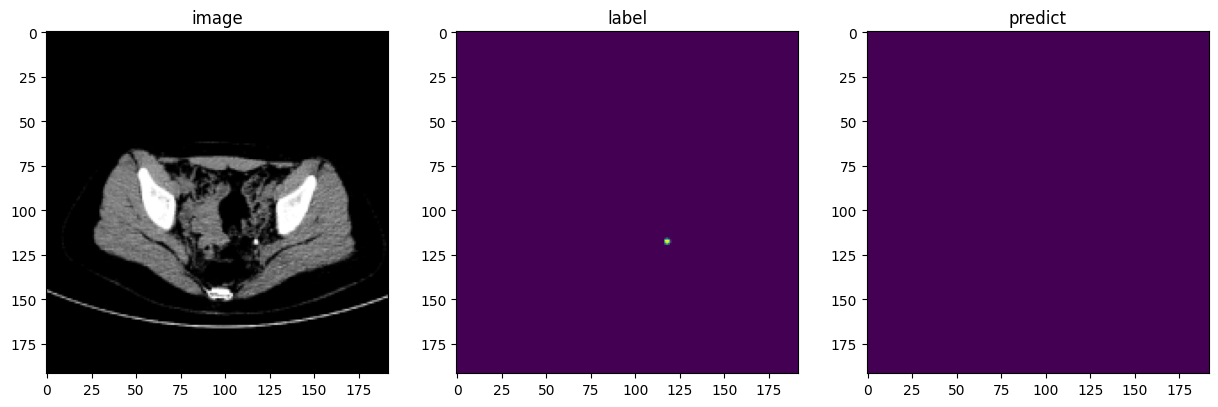

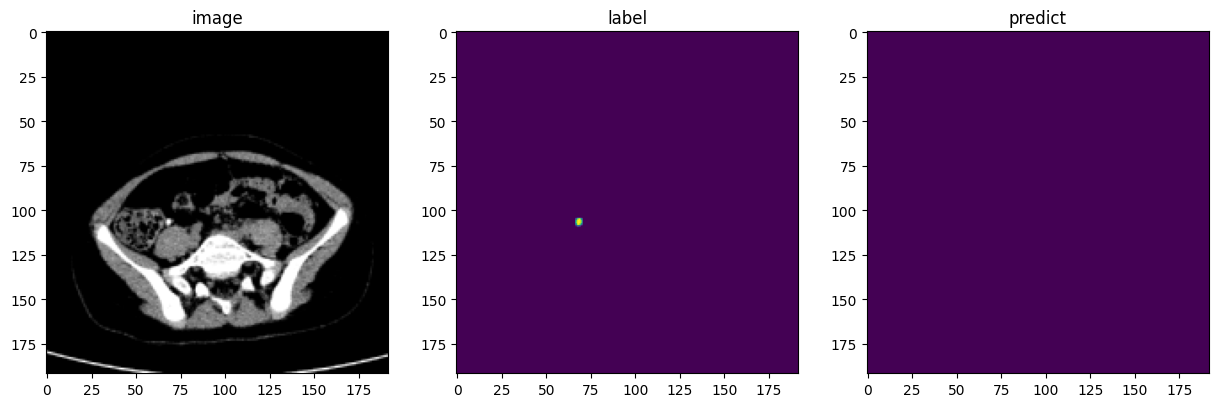

In [22]:
#root_dir = '/content/drive/MyDrive/Medtech_dataset/dataset/weights'
#model.load_state_dict(torch.load(os.path.join(root_dir, "Adam_UNETR_metric_model_23.pth")))
model.eval()
with torch.no_grad():
  for i, val_data in enumerate(train_loader):
      idx = 64
      roi_size = (192, 192, 128)
      sw_batch_size = 4
      image, label = prepare_one_batch(val_data, i, train_files)
      image_t, label_t = MetaTensor(image).to(device), MetaTensor(label).to(device)
      val_outputs = sliding_window_inference(image_t, roi_size, sw_batch_size, model)

      plt.figure("visualize", (15, 6))
      plt.subplot(1, 3, 1)
      plt.title("image")
      plt.imshow(image[0,0,:, :, idx], cmap="gray")
      plt.subplot(1, 3, 2)
      plt.title("label")
      plt.imshow(label[0,0, :, :, idx])
      plt.subplot(1, 3, 3)
      plt.title("predict")

      #print(image)
      #print(val_outputs.to(device))

      plt.imshow(torch.argmax(val_outputs, dim=1).detach().cpu()[0, :, :, idx])
      plt.show()